In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import Aircraft
import seaborn as sns
from labellines import labelLines

sns.set_palette('dark')

In [2]:
def digitiserData(data):
    dataX, dataY = zip(*[(float(datapoint.split(', ')[0]), float(datapoint.split(', ')[1])) for datapoint in data.split('; ')])
    return dataX, dataY

# International Standard Atmosphere

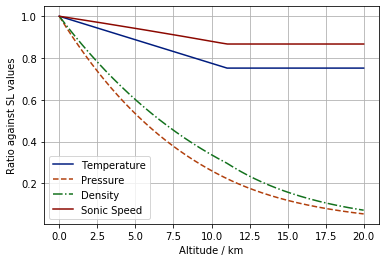

In [3]:
T_sl = 288.15
p_sl = 101325
rho_sl = 1.225
a_sl = 340.3

TRat = []
pRat = []
rhoRat = []
aRat = []

alts = np.arange(0,20,0.01)

for h in alts:
    if h <= 11:
        T = T_sl - 6.5*h
        TRat.append(T/T_sl)

        pRat.append((T/T_sl)**5.256)
        rhoRat.append((T/T_sl)**4.256)
        aRat.append((T/T_sl)**0.5)
    elif h <= 20:
        T = 216.65
        TRat.append(T/T_sl)

        tropRat = np.exp(-0.1577*(h-11))
        pRat.append(tropRat*22631/p_sl)
        rhoRat.append(tropRat*0.364/rho_sl)
        aRat.append((T/T_sl)**0.5)


plt.figure(figsize=[6,4])
plt.plot(alts, TRat, label='Temperature')
plt.plot(alts, pRat, label='Pressure', linestyle='--')
plt.plot(alts, rhoRat, label='Density', linestyle='-.')
plt.plot(alts, aRat, label='Sonic Speed')

plt.xlabel('Altitude / km')
plt.ylabel('Ratio against SL values')
plt.legend()
plt.grid()

plt.show()

In [4]:
def ISAh(h):
    hIdx = np.where(alts==h)[0][0]
    temperature = TRat[hIdx] * T_sl
    pressure = pRat[hIdx] * p_sl
    density = rhoRat[hIdx] * rho_sl
    soundSpeed = aRat[hIdx] * a_sl

    return temperature, pressure, density, soundSpeed

# Fitting to Humidity of Contrail Formation

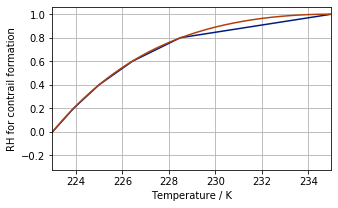

[-2.11945474e-05  1.99228746e-02 -7.02668394e+00  1.10205996e+03
 -6.48519007e+04]


In [5]:
def fitPoly(x,y,order,xFit):
    fitParams = np.polyfit(x, y, order)

    yFit = np.zeros(len(xFit))

    for i in range(order+1):
        yFit += fitParams[i]*xFit**(order-i)

    return yFit, fitParams

RHData = '235, 8.179797542997543; 228.4891891891892, 9.212033415233414; 226.42702702702704, 9.516202457002457; 224.98918918918918, 9.73348796068796; 223.8918918918919, 9.907349385749384; 222.9837837837838, 10.037692383292383'
TRHData,_ = digitiserData(RHData)
RHData = list(np.arange(1,-.1,-0.2))

TRHData = list(reversed(TRHData)) + [235*2-T for T in TRHData]
RHData = list(reversed(RHData)) + RHData

TFit = np.arange(222, 235.1, 0.1)
hFit = (288.15-TFit)/6.5
RHFit, fitParams = fitPoly(TRHData, RHData, 4, TFit)

ax1 = plt.figure(figsize=[5,3])
plt.plot(TRHData[:6], RHData[:6], label='RH against T from data')
plt.plot(TFit, RHFit, label='Fit line for RH against T')

plt.xlabel('Temperature / K')
plt.ylabel('RH for contrail formation')
plt.xlim([min(TRHData), max(TRHData[:6])])
plt.grid()
plt.show()

print(fitParams)

# Optimise L/D with Mach number

In [6]:
aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':40_000, 'W_F':74_000, # Weight specs
                'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                'timestep':10, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':1, 'dontCheckMach':False, 'dontCheckW_P':False} # Model parameters

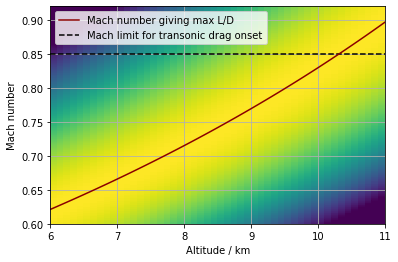

In [7]:
MRange = np.arange(0.6,1,0.001)
hRange = np.arange(6,11.1,0.1)
MLDMax = []
LDMesh = np.zeros((len(hRange), len(MRange)))

for i, h in enumerate(hRange):
    LDs = []

    for j, M in enumerate(MRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.updateAllFlightValues(h, MOvrd=M, ft=False)
        LDs.append(1/aircraft.beta)

    LDMesh[i,:] = LDs
    MLDMax.append(aircraft.EASOpt/(aircraft.rho/aircraft.rho_sl)**0.5/aircraft.a)

plt.figure(figsize=[6,4])

MMesh, hMesh = np.meshgrid(MRange, hRange)

plt.pcolormesh(hMesh, MMesh, LDMesh, vmin=np.min(LDMesh)+3)
plt.plot(hRange, MLDMax, color='darkred', label='Mach number giving max L/D')
plt.hlines(0.85, min(hRange), max(hRange), linestyle='--', color='black', label='Mach limit for transonic drag onset')

plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.ylim([0.6, 0.92])
plt.yticks(np.arange(0.6, 0.9, 0.05))
plt.legend(loc='upper left')
plt.grid()
plt.show()


# Effect of speed ratio on L/D and overall efficiency

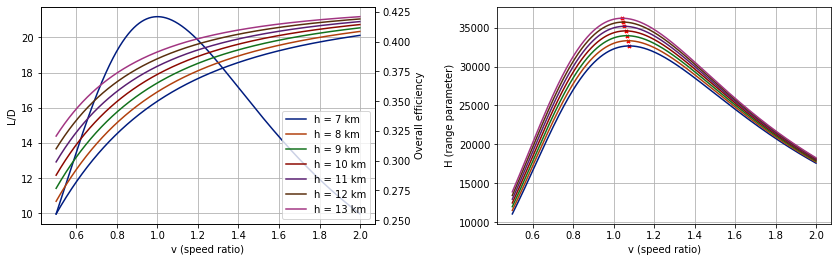

7 1.077
8 1.071
9 1.065
10 1.059
11 1.053
12 1.047
13 1.042


In [8]:
altitudes = np.arange(7,14,1)
vRatRange = np.arange(0.5, 2, 0.001)

LDs = np.zeros((len(altitudes), len(vRatRange)))
effs = np.zeros((len(altitudes), len(vRatRange)))

for i, h in enumerate(altitudes):
    for j, vRat in enumerate(vRatRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.vRat = vRat

        aircraft.updateAllFlightValues(h, ft=False)

        LDs[i,j] = 1/aircraft.beta
        effs[i,j] = aircraft.effOverall

fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)

ax1.plot(vRatRange, LDs[0])
ax2 = ax1.twinx()
ax2.plot(vRatRange, effs.transpose())

ax1.set_xlabel('v (speed ratio)')
ax1.set_ylabel('L/D')
ax2.set_ylabel('Overall efficiency')

ax2.legend([f'h = {h} km' for h in altitudes])
ax1.grid()

plt.subplot(1,2,2)

Hs = 42700*LDs*effs/9.81
maxHs = [max(Hs[i,:]) for i in range(len(altitudes))]
maxVs = [round(vRatRange[np.where(Hs[i,:]==maxHs[i])[0][0]], 3) for i in range(len(altitudes))]

plt.plot(vRatRange, Hs.transpose())
plt.scatter(maxVs, maxHs, marker='x', color='red', s=10)
plt.xlabel('v (speed ratio)')
plt.ylabel('H (range parameter)')
plt.grid()

fig.tight_layout(pad=2.0)
plt.show()

for i in range(len(maxHs)):
    print(altitudes[i], maxVs[i])

In [9]:
def findOptimalSpeedRatio(h):
    vRatRange = np.arange(0.9, 1.3, 0.001)

    LDs = np.zeros(len(vRatRange))
    effs = np.zeros(len(vRatRange))

    for i, vRat in enumerate(vRatRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.vRat = vRat

        aircraft.updateAllFlightValues(h, ft=False)

        LDs[i] = 1/aircraft.beta
        effs[i] = aircraft.effOverall
        
    Hs = 42700*LDs*effs/9.81

    maxH = max(Hs)

    return round(vRatRange[np.where(Hs==maxH)[0][0]],3)

# Constant altitude constant Mach flight

In [10]:
def simulateFlight(aircraftSpecs, altitudes, M=-1):
    aircraft = Aircraft(aircraftSpecs)

    timeData = {'distances':[],
    'times':[],
    'fuelBurns':[],
    'machs':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}
    
    distance = 0.0
    altIdx = 0

    while aircraft.W_F > 0:
        if distance > altitudes[altIdx+1, 0]:
            # If distance for next stage in altitude sequence has been reached
            altIdx += 1
        alt = altitudes[altIdx, 1]
        
        aircraft.updateAllFlightValues(alt, ft=False, MOvrd=M)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['times'].append(aircraft.time)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

    gCO2PPKM = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    gNOxPPKM = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    gH2OPPKM = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    avgContrailChance = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    
    if M!=-1:
        print(f"M = {M:.2f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {gCO2PPKM:.2f} g/passkm | NOx pollution: {gNOxPPKM:.2f} g/passkm | \
H2O contrail pollution: {gH2OPPKM:.2f} g/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['times'][-1]/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
    else:
        print(f"v = {aircraftSpecs['vRat']:.3f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {gCO2PPKM:.2f} g/passkm | NOx pollution: {gNOxPPKM:.2f} g/passkm | \
H2O contrail pollution: {gH2OPPKM:.2f} g/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['times'][-1]/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")

    return timeData

M = 0.60 | Start altitude: 9.50 | Distance flown: 11420 km | CO2 pollution: 83.38 g/passkm | NOx pollution: 1.75 g/passkm | H2O contrail pollution: 15.37 g/passkm | Avg contrail chance = 22.14 % | Time of flight: 17.53 hours | Number of iterations: 6311
M = 0.70 | Start altitude: 9.50 | Distance flown: 12829 km | CO2 pollution: 74.22 g/passkm | NOx pollution: 1.76 g/passkm | H2O contrail pollution: 13.68 g/passkm | Avg contrail chance = 18.98 % | Time of flight: 16.88 hours | Number of iterations: 6077
M = 0.80 | Start altitude: 9.50 | Distance flown: 13094 km | CO2 pollution: 72.72 g/passkm | NOx pollution: 2.00 g/passkm | H2O contrail pollution: 13.41 g/passkm | Avg contrail chance = 16.61 % | Time of flight: 15.07 hours | Number of iterations: 5427
M = 0.85 | Start altitude: 9.50 | Distance flown: 12899 km | CO2 pollution: 73.82 g/passkm | NOx pollution: 2.20 g/passkm | H2O contrail pollution: 13.61 g/passkm | Avg contrail chance = 15.63 % | Time of flight: 13.98 hours | Number of i

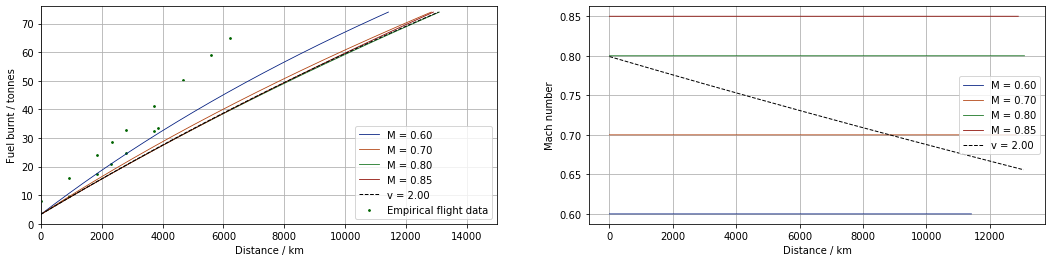

In [11]:
fuelBurnData = '-13.779527559055055, 2508.960573476652; 930.1181102362204, 9677.419354838668; 1860.236220472441, 17275.985663082407; 2321.850393700787, 21003.584229390646; 2790.354330708661, 24587.81362007164; 3727.36220472441, 32329.749103942624; 3861.712598425197, 33548.38709677418; 0, 7956.98924731178; 926.6732283464567, 15985.663082437255; 1853.3464566929133, 24157.706093189918; 2328.740157480315, 28458.78136200717; 2790.354330708661, 32616.4874551971; 3727.36220472441, 41290.32258064514; 4664.370078740157, 50179.21146953403; 5594.488188976376, 58996.415770609296; 6204.232283464566, 65089.605734767'
notesSFB, notesFB = digitiserData(fuelBurnData)
notesFB = np.array(notesFB)/1000

plt.figure(figsize=[18,4])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

altitudes = np.array([[0,9.5],[20000,0]])

MRange = [0.6, 0.7, 0.8, 0.85]

# Plot fuel burn at constant Mach numbers
for M in MRange:
    timeData = simulateFlight(aircraftSpecs, altitudes, M=M)
    ax1.plot(timeData['distances'], timeData['fuelBurns'], label=f'M = {M:.2f}', linewidth=0.8)
    ax2.plot(timeData['distances'], timeData['machs'], label=f'M = {M:.2f}', linewidth=0.8)

timeData = simulateFlight(aircraftSpecs, altitudes)

# Plot fuel burn with constant vRat as a benchmark
ax1.plot(timeData['distances'], timeData['fuelBurns'], color='black', label=f'v = {vRat:.2f}', linewidth=1, linestyle='--')

ax1.scatter(notesSFB, notesFB, s=3, color='darkgreen', label='Empirical flight data')

ax1.set_xlabel('Distance / km')
ax1.set_ylabel('Fuel burnt / tonnes')
ax1.set_xlim([0,15000])
ax1.set_ylim([0,76])
# ax1.set_yticks(np.arange(0,W_F/1000+5,5))
ax1.grid()
ax1.legend()

# Plot Mach number over time for the optimised
ax2.plot(timeData['distances'], timeData['machs'], color='black', label=f'v = {vRat:.2f}', linewidth=1, linestyle='--')

ax2.set_xlabel('Distance / km')
ax2.set_ylabel('Mach number')
ax2.grid()
ax2.legend()
plt.show()

# Constant speed ratio flight and stepped Cruise

In [12]:
def findAlt4CruiseMach(vRat, MCruise):
    betaOpt = 1/21.176

    beta = 0.5 * betaOpt * (vRat**2 + 1/vRat**2)

    if vRat<1:
        Cl = (beta + (beta**2 - 4*0.0446*0.0125)**0.5) / (2*0.0446)
    else:
        Cl = (beta - (beta**2 - 4*0.0446*0.0125)**0.5) / (2*0.0446)

    pRatio = 2*(220000-74000*0.015)*9.81 / (p_sl * Cl * 1.4 * MCruise**2 * 315)

    diffP = [abs(p - pRatio) for p in pRat]

    idx = diffP.index(min(diffP))

    h = alts[idx]

    return h

In [13]:
def simulateSteppedCruise(aircraftSpecs, vRat, startAlt, climbMachThresh, climbAlt, limitAlt=-1, suppressStats=False):
    aircraft = Aircraft(aircraftSpecs)
    aircraft.dontCheckMach = True
    aircraft.vRat = vRat

    timeData = {'distances':[],
    'altitudes':[],
    'times':[],
    'fuelBurns':[],
    'machs':[],
    'vRats':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}

    alt = startAlt

    while aircraft.W_F > 0:
        aircraft.updateAllFlightValues(alt, ft=False)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['altitudes'].append(aircraft.h)
        timeData['times'].append(aircraft.time)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['vRats'].append(aircraft.vRat)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

        if timeData['machs'][-1] < climbMachThresh:
            alt += climbAlt
            if limitAlt!=-1 and alt > limitAlt:
                alt = limitAlt
        
    timeData['gCO2PPKM'] = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    timeData['gNOxPPKM'] = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    timeData['gH2OPPKM'] = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    timeData['avgContrailChance'] = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    if timeData['distances'][-1] > 12000:
        timeData['timeTo12000'] = timeData['times'][np.where(np.array(timeData['distances']) > 12000)[0][0]]
    else:
        timeData['timeTo12000'] = timeData['times'][-1]/timeData['distances'][-1] * 12000
    
    if suppressStats==False:
        print(f"v = {timeData['vRats'][0]:.3f} | Start altitude: {startAlt:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {timeData['gCO2PPKM']:.2f} g/passkm | NOx pollution: {timeData['gNOxPPKM']:.2f} g/passkm | \
H2O contrail pollution: {timeData['gH2OPPKM']:.2f} g/passkm | Avg contrail chance = {timeData['avgContrailChance']:.2f} % | Time to 12000: {timeData['timeTo12000']/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
        
    return timeData

Constant altitude cruise:
v = 1.000 | Start altitude: 9.50 | Distance flown: 13067 km | CO2 pollution: 72.87 g/passkm | NOx pollution: 1.82 g/passkm | H2O contrail pollution: 13.44 g/passkm | Avg contrail chance = 18.37 % | Time to 12000: 15.15 hours | Number of iterations: 5989
v = 1.000 | Start altitude: 10.00 | Distance flown: 13209 km | CO2 pollution: 72.09 g/passkm | NOx pollution: 1.74 g/passkm | H2O contrail pollution: 31.84 g/passkm | Avg contrail chance = 42.67 % | Time to 12000: 14.68 hours | Number of iterations: 5871
v = 1.000 | Start altitude: 10.22 | Distance flown: 13272 km | CO2 pollution: 71.75 g/passkm | NOx pollution: 1.70 g/passkm | H2O contrail pollution: 33.02 g/passkm | Avg contrail chance = 43.84 % | Time to 12000: 14.47 hours | Number of iterations: 5819
v = 1.000 | Start altitude: 11.00 | Distance flown: 13486 km | CO2 pollution: 70.61 g/passkm | NOx pollution: 1.59 g/passkm | H2O contrail pollution: 32.49 g/passkm | Avg contrail chance = 41.74 % | Time to 120

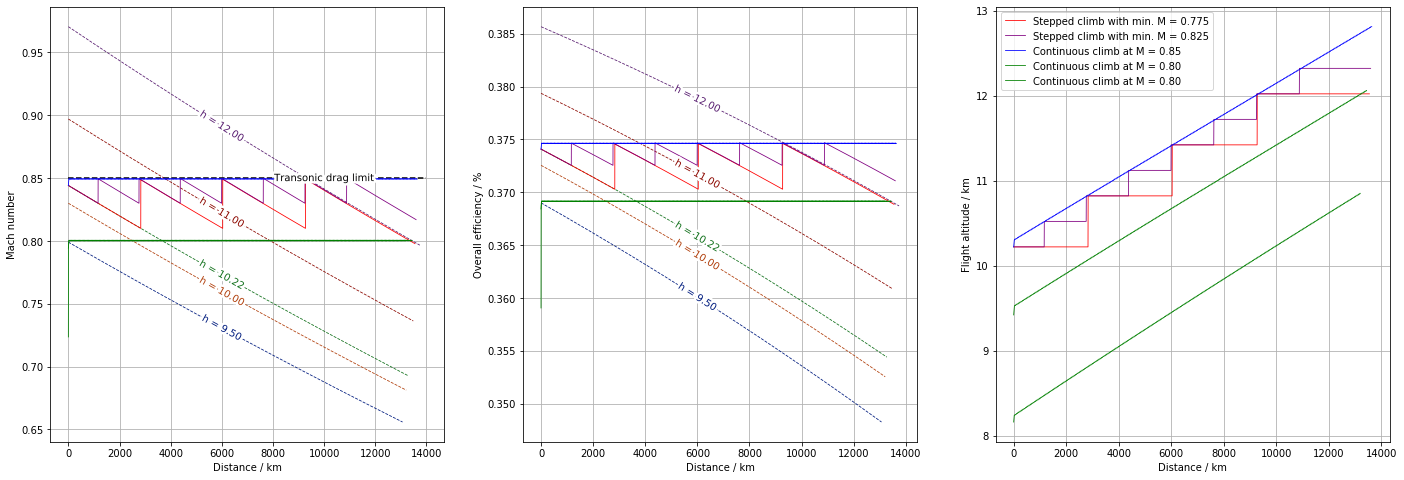

In [22]:
# Plot the Mach number following a speed ratio for different altitudes
plt.figure(figsize=[24,8])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

vRat = 1

hStart = findAlt4CruiseMach(vRat, 0.85)
altitudes = [9.5,10] + [hStart] + [11,12]

# Constant altitude cruise
print('Constant altitude cruise:')
for h in altitudes:
    timeData = simulateSteppedCruise(aircraftSpecs, vRat, h, 0, 0.1)

    ax1.plot(timeData['distances'], timeData['machs'], label=f'h = {h:.2f}', linewidth=0.8, linestyle='--')
    ax2.plot(timeData['distances'], timeData['effOveralls'], label=f'h = {h:.2f}', linewidth=0.8, linestyle='--')

ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')

# Stepped climb cruise
print('Stepped climb cruise:')
timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, 0.81, 0.6, limitAlt=hStart+3*0.6)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8, color='red')
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8, color='red')
ax3.plot(timeData['distances'], timeData['altitudes'], linewidth=0.8, color='red', label='Stepped climb with min. M = 0.775')

timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, 0.83, 0.3, limitAlt=hStart+7*0.3)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8, color='purple')
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8, color='purple')
ax3.plot(timeData['distances'], timeData['altitudes'], linewidth=0.8, color='purple', label='Stepped climb with min. M = 0.825')

# Continuous climb cruise
print('Continuous climb cruise')
timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, 0.849, 0.01)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8, color='blue')
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8, color='blue')
ax3.plot(timeData['distances'], timeData['altitudes'], linewidth=0.8, color='blue', label='Continuous climb at M = 0.85')

hStart = findAlt4CruiseMach(1, 0.8)
timeData = simulateSteppedCruise(aircraftSpecs, 1, hStart, 0.8, 0.01)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8, color='green')
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8, color='green')
ax3.plot(timeData['distances'], timeData['altitudes'], linewidth=0.8, color='green', label='Continuous climb at M = 0.80')

hStart = findAlt4CruiseMach(1.1,0.8)
timeData = simulateSteppedCruise(aircraftSpecs, 1.1, hStart, 0.8, 0.01)
ax1.plot(timeData['distances'], timeData['machs'], linewidth=0.8, color='green')
ax2.plot(timeData['distances'], timeData['effOveralls'], linewidth=0.8, color='green')
ax3.plot(timeData['distances'], timeData['altitudes'], linewidth=0.8, color='green', label='Continuous climb at M = 0.80')

# ax1
ax1.set_xlabel('Distance / km')
ax1.set_ylabel('Mach number')
ax1.grid()

# ax2
ax2.set_xlabel('Distance / km')
ax2.set_ylabel('Overall efficiency / %')
ax2.grid()

# ax3
ax3.set_xlabel('Distance / km')
ax3.set_ylabel('Flight altitude / km')
ax3.grid()
ax3.legend()

xLabels = [6000]*len(altitudes) + [10000]
lines = ax1.get_lines()
labelLines(lines[:len(altitudes)+1], drop_label=True, align=True, xvals=xLabels)

xLabels = [6000]*len(altitudes) + [10000]
lines = ax2.get_lines()
labelLines(lines[:len(altitudes)], drop_label=True, align=True, xvals=xLabels)

plt.show()

# Effect of v on range and pollution

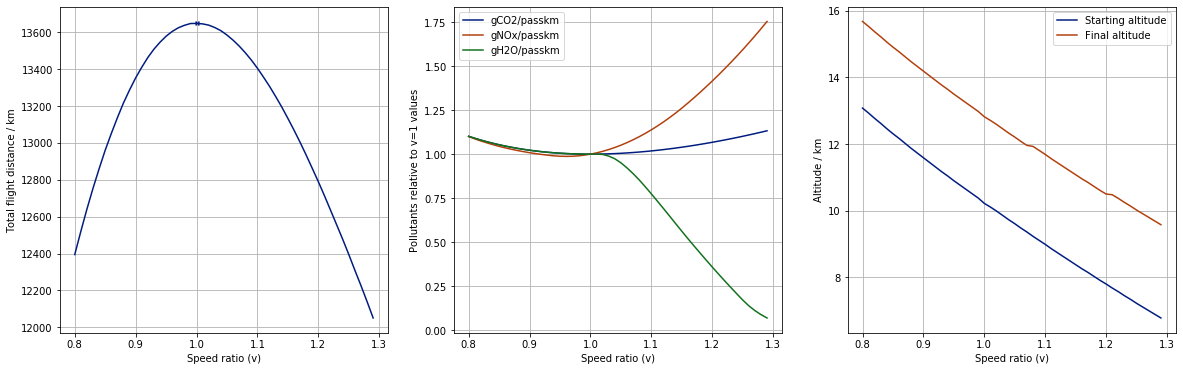

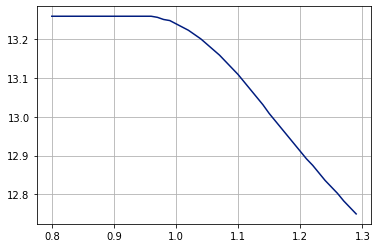

In [15]:
# Stepped cruise with different speed ratios
vRatRange = np.arange(0.8,1.3,0.01)
totDists = []
avgHs = []
gCO2PPKMs = []
gNOxPPKMs = []
gH2OPPKMs = []
startAlts = []
finalAlts = []
flightTimes = []

# Baseline figures at vRat = 1
hStart = findAlt4CruiseMach(1, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, 1, hStart, 0.849, 0.1, suppressStats=True)
gCO2PPKM_base = timeData['gCO2PPKM']
gNOxPPKM_base = timeData['gNOxPPKM']
gH2OPPKM_base = timeData['gH2OPPKM']


plt.figure(figsize=[20,6])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for vRat in vRatRange:
    hStart = findAlt4CruiseMach(vRat, 0.85)
    timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, 0.849, 0.1, suppressStats=True)

    totDists.append(timeData['distances'][-1])
    avgHs.append(np.mean(timeData['Hs']))
    gCO2PPKMs.append(timeData['gCO2PPKM'] / gCO2PPKM_base)
    gNOxPPKMs.append(timeData['gNOxPPKM'] / gNOxPPKM_base)
    gH2OPPKMs.append(timeData['gH2OPPKM'] / gH2OPPKM_base)
    startAlts.append(timeData['altitudes'][0])
    finalAlts.append(timeData['altitudes'][-1])
    flightTimes.append(timeData['timeTo12000']/3600)


ax1.plot(vRatRange, totDists, label='Total distance travelled / km')
# ax1.plot(vRatRange, avgHs, label='Average H value throughout flight / km')
ax1.scatter(round(vRatRange[totDists.index(max(totDists))], 3), round(max(totDists), 3), marker='x', s=15)
# ax1.scatter(round(vRatRange[avgHs.index(max(avgHs))], 3), round(max(avgHs), 3), marker='x', s=15)
# ax1.legend()
ax1.grid()
ax1.set_xlabel('Speed ratio (v)')
ax1.set_ylabel('Total flight distance / km')

ax2.plot(vRatRange, gCO2PPKMs, label='gCO2/passkm')
ax2.plot(vRatRange, gNOxPPKMs, label='gNOx/passkm')
ax2.plot(vRatRange, gH2OPPKMs, label='gH2O/passkm')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Speed ratio (v)')
ax2.set_ylabel('Pollutants relative to v=1 values')

ax3.plot(vRatRange, startAlts, label='Starting altitude')
ax3.plot(vRatRange, finalAlts, label='Final altitude')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Speed ratio (v)')
ax3.set_ylabel('Altitude / km')

plt.show()

plt.plot(vRatRange, flightTimes)
plt.grid()
plt.show()



# Effect of Mach on range and pollution

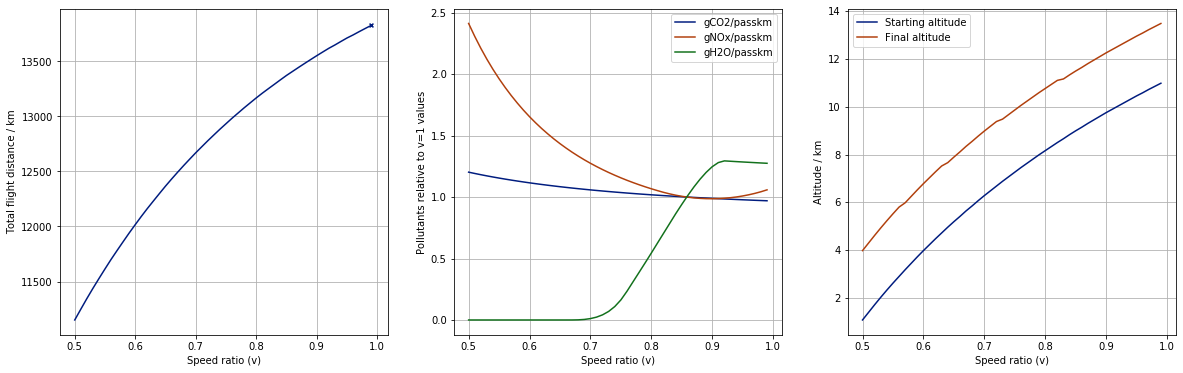

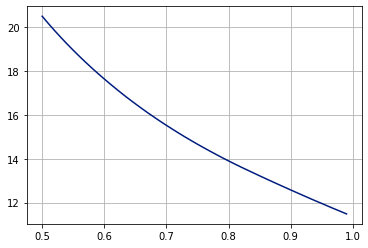

In [21]:
MRange = np.arange(0.5,1,0.01)
vRat = 1.1

totDists = []
avgHs = []
gCO2PPKMs = []
gNOxPPKMs = []
gH2OPPKMs = []
startAlts = []
finalAlts = []
flightTimes = []

# Baseline figures at vRat = 1
hStart = findAlt4CruiseMach(vRat, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, 0.849, 0.1, suppressStats=True)
gCO2PPKM_base = timeData['gCO2PPKM']
gNOxPPKM_base = timeData['gNOxPPKM']
gH2OPPKM_base = timeData['gH2OPPKM']


plt.figure(figsize=[20,6])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for M in MRange:
    hStart = findAlt4CruiseMach(vRat, M)
    timeData = simulateSteppedCruise(aircraftSpecs, vRat, hStart, M-0.01, 0.1, suppressStats=True)

    totDists.append(timeData['distances'][-1])
    avgHs.append(np.mean(timeData['Hs']))
    gCO2PPKMs.append(timeData['gCO2PPKM'] / gCO2PPKM_base)
    gNOxPPKMs.append(timeData['gNOxPPKM'] / gNOxPPKM_base)
    gH2OPPKMs.append(timeData['gH2OPPKM'] / gH2OPPKM_base)
    startAlts.append(timeData['altitudes'][0])
    finalAlts.append(timeData['altitudes'][-1])
    flightTimes.append(timeData['timeTo12000']/3600)


ax1.plot(MRange, totDists, label='Total distance travelled / km')
# ax1.plot(vRatRange, avgHs, label='Average H value throughout flight / km')
ax1.scatter(round(MRange[totDists.index(max(totDists))], 3), round(max(totDists), 3), marker='x', s=15)
# ax1.scatter(round(vRatRange[avgHs.index(max(avgHs))], 3), round(max(avgHs), 3), marker='x', s=15)
# ax1.legend()
ax1.grid()
ax1.set_xlabel('Speed ratio (v)')
ax1.set_ylabel('Total flight distance / km')

ax2.plot(MRange, gCO2PPKMs, label='gCO2/passkm')
ax2.plot(MRange, gNOxPPKMs, label='gNOx/passkm')
ax2.plot(MRange, gH2OPPKMs, label='gH2O/passkm')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Speed ratio (v)')
ax2.set_ylabel('Pollutants relative to v=1 values')

ax3.plot(MRange, startAlts, label='Starting altitude')
ax3.plot(MRange, finalAlts, label='Final altitude')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Speed ratio (v)')
ax3.set_ylabel('Altitude / km')

plt.show()

plt.plot(MRange, flightTimes)
plt.grid()
plt.show()

